## Overview

Plots and stats of the A Thaliana dataset, after removing outliers.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import labeled_clustermap, get_clusters, corr_heatmap, plot_full_test
from subpred.eval import quick_test, models_quick_compare, full_test

## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,0.0,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,2.A,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [4]:
df.keywords_transport.value_counts()

Sugar transport         118
Amino-acid transport     47
Name: keywords_transport, dtype: int64

In [5]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                        102
Cell membrane;Membrane;Transmembrane                           51
Endoplasmic reticulum;Membrane;Transmembrane                    7
Membrane;Mitochondrion;Transmembrane                            2
Membrane;Plastid inner membrane;Transmembrane                   1
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane      1
Cell membrane;Membrane;Nucleus;Transmembrane                    1
Name: keywords_location, dtype: int64

In [6]:
df.keywords_transport_related.value_counts()

Transport             107
Symport;Transport      39
Antiport;Transport     19
Name: keywords_transport_related, dtype: int64

#### TCDB


In [7]:
df.tcdb_class.value_counts()

0.0    108
2.A     57
Name: tcdb_class, dtype: int64

## Feature generation

In [8]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f3d671641c0>)

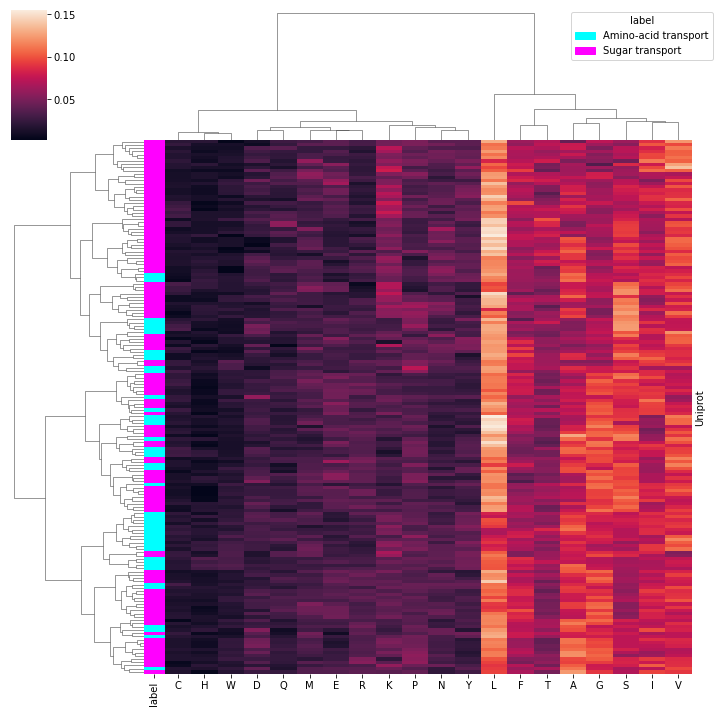

In [9]:
labeled_clustermap(df_aac, labels, xlabels="auto")

### PAAC plot

The distinction between dipeptides is much clearer after removing the outliers. The most common PAAC amino acids now correspond to the most common AAC residues.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f3d59d98fa0>)

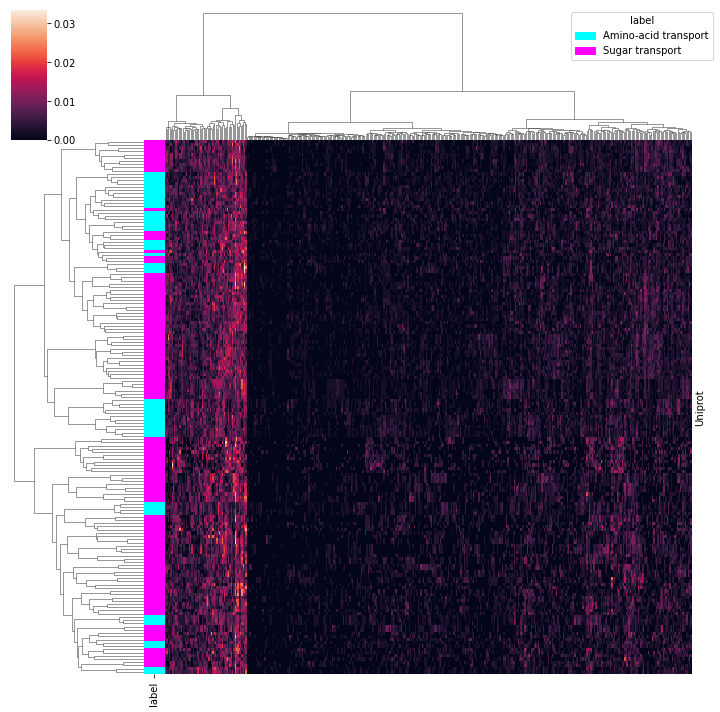

In [10]:
labeled_clustermap(df_paac, labels)

In [11]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
from collections import Counter
print(len(cluster1))
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] +=1
    counter[dipeptide[1]] +=1

counter

62


Counter({'A': 16,
         'F': 15,
         'G': 15,
         'I': 16,
         'L': 17,
         'S': 16,
         'T': 12,
         'V': 16,
         'P': 1})

#### Antiport, Symport, Uniport

({'Antiport;Transport': 'cyan',
  'Symport;Transport': 'magenta',
  'Transport': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f3d62405e50>)

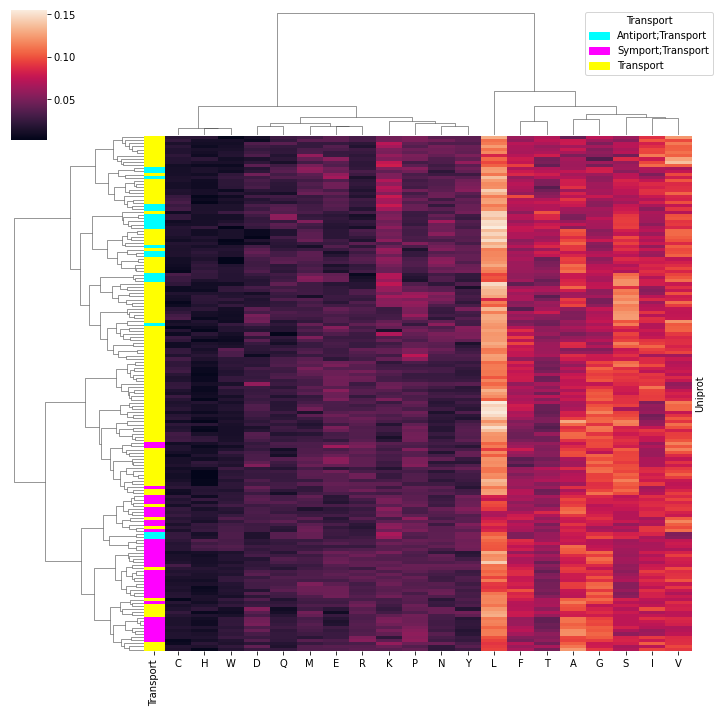

In [12]:
labeled_clustermap(df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto")

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

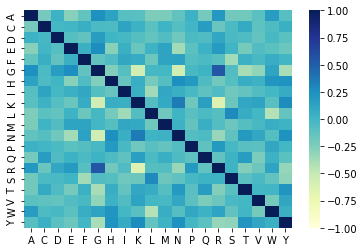

In [13]:
corr_heatmap(df_aac)

<AxesSubplot:>

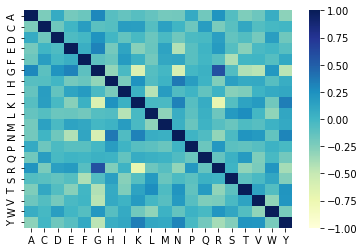

In [14]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

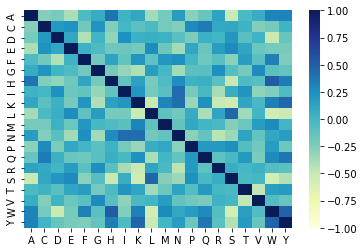

In [15]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

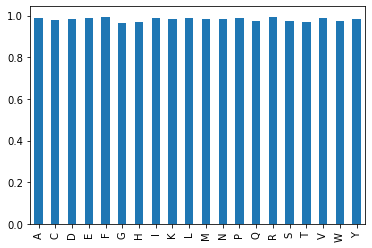

In [16]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

## Additional plots

### TCDB class

The unclassified proteins mix well with the 2.A proteins, suggesting that they share the same sequence composition

({'0.0': 'cyan', '2.A': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f3d4cc891f0>)

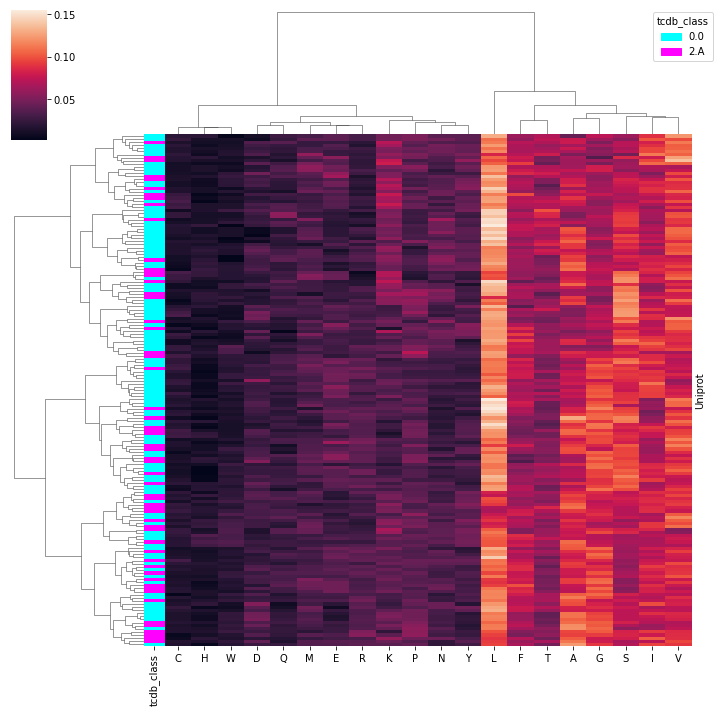

In [17]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")

<AxesSubplot:>

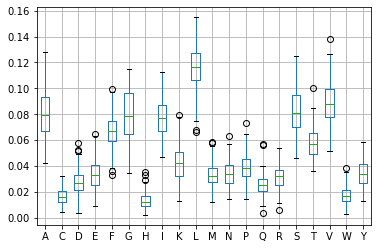

In [18]:
df_aac.boxplot()

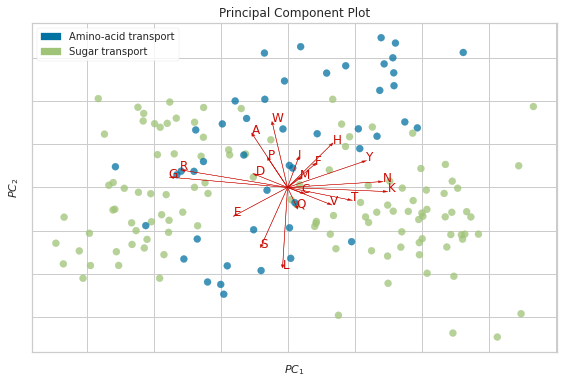

/home/andy/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


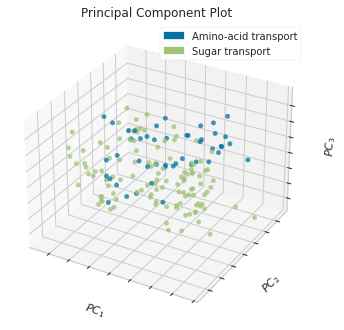

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [19]:
from yellowbrick.features import PCA as PCAPlot
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels.ravel())

# labels
pca_plot = PCAPlot(
    classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns
)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(
    classes=le.classes_,
    scale=True,
    features=df_aac.columns,
    projection=3,
)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()


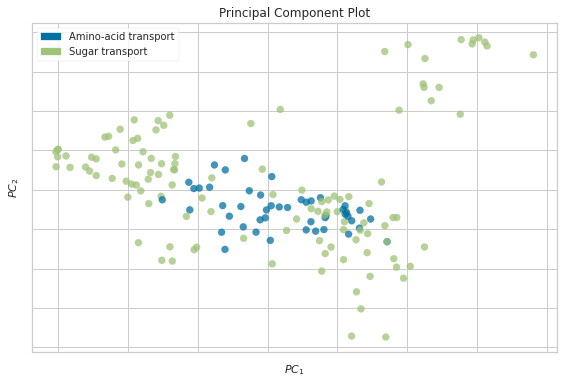

/home/andy/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


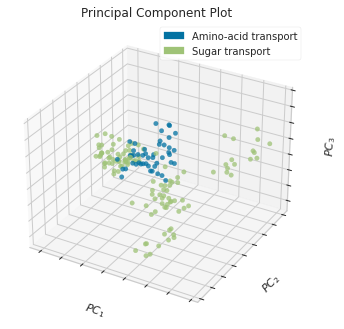

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [20]:
from yellowbrick.features import PCA as PCAPlot
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels.ravel())

# labels
pca_plot = PCAPlot(
    classes=le.classes_, scale=True, features=df_paac.columns
)
pca_plot.fit_transform(df_paac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(
    classes=le.classes_,
    scale=True,
    features=df_paac.columns,
    projection=3,
)
pca_plot.fit_transform(df_paac.to_numpy(), y)
pca_plot.show()

In [1]:
# TODO This is from old notebook, turn into function!

In [ ]:

df_aaindex = pd.read_csv("NAKH900111.csv")
col1 = pd.Series(
    data=df_aaindex.loc[0].tolist(),
    index=df_aaindex.columns.to_series().apply(lambda x: x[0]).tolist(),
)
col2 = pd.Series(
    data=df_aaindex.loc[0].tolist(),
    index=df_aaindex.columns.to_series().apply(lambda x: x[2]).tolist(),
)
aaindex = pd.concat([col1,col2]).sort_index()

df_plot = pd.DataFrame().assign(Helix_Propensity=aaindex)
df_plot.Helix_Propensity = minmax_scale(df_plot.Helix_Propensity)

In [22]:
from sklearn.preprocessing import minmax_scale


df_aac_sugar = df_aac.loc[labels[labels == "Sugar transport"].index.tolist()]
df_aac_amino = df_aac.loc[labels[labels == "Amino-acid transport"].index.tolist()]

df_aac_sugar_long = df_aac_sugar.melt(var_name="Amino acid", value_name="Normalized score").assign(Measure = "AA Frequency (Sugar)")
df_aac_amino_long = df_aac_amino.melt(var_name="Amino acid", value_name="Normalized score").assign(Measure = "AA Frequency (Amino-acid)")


In [ ]:
kbest = SelectKBest(k=20)

labels = df_labels.labels
labels = np.where(labels == "Amino-acid transport", 0, 1)

kbest.fit(df_aac, labels)

feature_importances_kbest = pd.Series(index = kbest.feature_names_in_, data=kbest.scores_).sort_index()
# feature_importances_kbest = minmax_scale(feature_importances_kbest)
feature_importances_kbest = feature_importances_kbest / sum(feature_importances_kbest)

df_plot = df_plot.assign(
    ANOVA = feature_importances_kbest
)

In [ ]:
df_plot = df_plot.sort_values("ANOVA", ascending=False).reset_index()
df_plot = df_plot.rename(columns = {"Helix_Propensity": "Helix propensity", "ANOVA": "Feature importance", "index": "Amino acid"})
df_plot

In [ ]:
df_molten = df_plot.melt(id_vars=["Amino acid"], var_name="Measure", value_name="Normalized score")

df_molten = pd.concat([df_molten, df_aac_amino_long, df_aac_sugar_long])
sns.barplot(
    data=df_molten[df_molten.Measure != "Helix propensity"], x="Amino acid", y="Normalized score", hue="Measure"
)
plt.savefig("aac_feature_importance.png", dpi=300)